#### Testing Methods to Classify Pitch Type

In [2]:
from pybaseball import statcast_pitcher, playerid_lookup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#Simple function to create a one-step process to retrieve pitch-level data 
def get_data(last_name, first_name, start_date, end_date):
    id_df = playerid_lookup(last_name, first_name)
    id = id_df['key_mlbam'].iloc[0]
    data = statcast_pitcher(start_date, end_date, player_id = id)
    return data

### K-Means Clustering

+ This first part of the analysis will be clustering based on pitch data from Corbin Burnes' 2021 season. I want to classify pitch type using the most relevent and recent data (up to that point in time) since pitchers are known to adjust their arsenal in the offseason, which could contribute to inaccuracy if pitch shapes did change drastically year over year. 

In [6]:
#retrieving Statcast pitch-level data
data = get_data('burnes', 'corbin', '2021-04-01', '2021-10-03')

Gathering player lookup table. This may take a moment.
Gathering Player Data


In [14]:
#only selecting pitch-specific columns for our analysis
#there were lots of missing values to deprecated fields so this subset eliminates most of those as well
pitch_metrics = data[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 
                     'release_spin_rate', 'release_extension', 'spin_axis']].copy()
pitch_metrics.head()

,pitch_type,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,release_spin_rate,release_extension,spin_axis
0,CU,81.4,-0.45,6.11,0.88,-0.31,2747.0,6.5,51.0
1,CU,81.1,-0.50,6.08,1.08,-0.28,2816.0,6.3,50.0
2,FC,95.7,-0.78,5.91,0.39,0.97,2764.0,6.4,186.0
3,FC,95.6,-0.82,5.86,0.35,0.88,2637.0,6.5,184.0
4,CH,89.8,-0.66,5.74,-1.45,0.55,2006.0,6.6,213.0


In [16]:
#dropping rows with null values
pitch_metrics.dropna(inplace = True)

In [14]:
#removing four-seam fastballs from our data since there were so few observations
#clustering was done with FF in the data but it was dispersed into almost every cluster with no clear distinction
pitch_metrics_5 = pitch_metrics.loc[pitch_metrics['pitch_type'] != 'FF'].copy()

In [16]:
#scaling data as required for K-Means clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_pitch_metrics = scaler.fit_transform(pitch_metrics_5[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 
                                                           'release_spin_rate', 'release_extension', 'spin_axis']])

In [18]:
#the scaled data was a numpy array, so it must be converting back into a pandas dataframe
scaled_pitch_metrics = pd.DataFrame(scaled_pitch_metrics, columns=['release_speed', 'release_pos_x', 'release_pos_z', 
                                                                    'pfx_x', 'pfx_z', 'release_spin_rate', 'release_extension', 
                                                                   'spin_axis'])

Text(0.5, 1.0, 'Fig : Elbow Diagram')

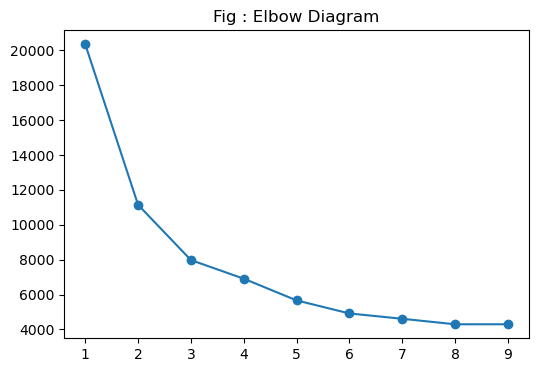

In [20]:
#generating an elbow diagram to show the best number of clusters
#this lines up perfectly with what we know about our data, since there are 5 pitches other than four-seam
# fastball thrown by Burnes
from sklearn.cluster import KMeans
cluster_range = range(1, 10)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(scaled_pitch_metrics)
    cluster_errors.append(clusters.inertia_)
plt.figure(figsize=(6,4))
plt.plot(cluster_range, cluster_errors, marker = "o")
plt.title( "Fig : Elbow Diagram")

In [22]:
#setting our k value, fitting our data, and adding a column to our dataframe that includes cluster label
k = 5
clusters = KMeans(k, random_state = 42)
clusters.fit(scaled_pitch_metrics)
pitch_metrics_5['clusterid'] = clusters.labels_

In [26]:
#displaying results for cluster 0
cluster_0 = pitch_metrics_5.loc[pitch_metrics_5['clusterid'] == 0]
cluster_0['pitch_type'].value_counts()

pitch_type
SL    217
FC      7
CU      2
Name: count, dtype: int64

In [28]:
##displaying results for cluster 1
cluster_1 = pitch_metrics_5.loc[pitch_metrics_5['clusterid'] == 1]
cluster_1['pitch_type'].value_counts()

pitch_type
FC    609
SI    194
SL      1
Name: count, dtype: int64

In [30]:
##displaying results for cluster 2
cluster_2 = pitch_metrics_5.loc[pitch_metrics_5['clusterid'] == 2]
cluster_2['pitch_type'].value_counts()

pitch_type
CU    471
SL      2
Name: count, dtype: int64

In [32]:
##displaying results for cluster 3
cluster_3 = pitch_metrics_5.loc[pitch_metrics_5['clusterid'] == 3]
cluster_3['pitch_type'].value_counts()

pitch_type
CH    248
SL      6
SI      2
FC      2
Name: count, dtype: int64

In [34]:
##displaying results for cluster 4
cluster_4 = pitch_metrics_5.loc[pitch_metrics_5['clusterid'] == 4]
cluster_4['pitch_type'].value_counts()

pitch_type
FC    733
SI     37
SL     12
Name: count, dtype: int64

### Hierarchical Clustering

In [38]:
from sklearn.cluster import AgglomerativeClustering

In [40]:
#setting our k value, fitting our data, and adding a column to our dataframe that includes cluster label
h_clusters = AgglomerativeClustering(5)
h_clusters.fit(scaled_pitch_metrics)
pitch_metrics_5['h_clusterid'] = h_clusters.labels_

In [42]:
pitch_metrics_5['pitch_type'].value_counts()

pitch_type
FC    1351
CU     473
CH     248
SL     238
SI     233
Name: count, dtype: int64

In [44]:
#displaying results for h_cluster 0
hcluster_0 = pitch_metrics_5.loc[pitch_metrics_5['h_clusterid'] == 0]
hcluster_0['pitch_type'].value_counts()

pitch_type
FC    1340
SL       8
CU       2
Name: count, dtype: int64

In [46]:
#displaying results for h_cluster 1
hcluster_1= pitch_metrics_5.loc[pitch_metrics_5['h_clusterid'] == 1]
hcluster_1['pitch_type'].value_counts()

pitch_type
CU    469
SL      1
Name: count, dtype: int64

In [48]:
#displaying results for h_cluster 2
hcluster_2 = pitch_metrics_5.loc[pitch_metrics_5['h_clusterid'] == 2]
hcluster_2['pitch_type'].value_counts()

pitch_type
CH    248
SL      7
CU      2
FC      2
Name: count, dtype: int64

In [50]:
#displaying results for h_cluster 3
hcluster_3 = pitch_metrics_5.loc[pitch_metrics_5['h_clusterid'] == 3]
hcluster_3['pitch_type'].value_counts()

pitch_type
SL    222
FC      9
Name: count, dtype: int64

In [52]:
#displaying results for h_cluster 4
hcluster_4 = pitch_metrics_5.loc[pitch_metrics_5['h_clusterid'] == 4]
hcluster_4['pitch_type'].value_counts()

pitch_type
SI    233
Name: count, dtype: int64

### Conclusion

+ Overall, there is a much clearer distinction between pitches when using the hierarchical clustering method as this method handles clustering where the shape of the clusters is more variable.
+ The H-Clusters have a better distinction of pitch type, as shown by each category having an overwhelming majority of a single pitch type and only a few mislabeled pitches. Curveballs were clustered almost perfectly, which makes sense given their spin direction and pfx_z (vertical movement) is much different than the other pitches.
+ Cutters (FC) and sliders (SL) were the hardest to single out. The movement profiles and velocities are somewhat similar. Plotting different variables could give a clearer picture as to the degree to which these pitches can blend together.
+ The K-Means clustering generated much greater confusion, with much more variabiity in each cluster. It had greater success with curveballs for the same reasons as mentioned above. 